# Introduction
This project showcases the ability to use data science toolkits on real-life problems. Geographical data can be scraped from the web, segmented, and subsequently applied to a relevant business problem. The analysis for this particular problem will be completed within Python, using primarily the Pandas, Geocoder, and Folium libraries, as well as Scikit-learn for K Means clustering.

# Business Problem

## The Question At Hand -

A potential client has established the following question:
We have a few coffee shops that perform very well throughout several neighborhoods of Manhattan New York City (Carnagie Hill and Chelsea). We are looking to expand our operations into Canada, particularly the Toronto area, however, we are unsure which neighborhood we should target in order to access a similar clientele to our Manhattan chain.
 
#### Question Analysis - 

Based on the question, it stands to reason that we can address this business problem using geospatial data, and clustering the neighborhoods of Manhattan and Toronto. We can look first at the neighborhoods of Manhattan that contain existing locations of our client's coffee shop, and we can characterize those neighborhoods based on surrounding venues.

Once characterized, we can do the same for the neighborhoods of Toronto, and then perform unsupervised clustering on the neighborhoods of both cities. If two neighborhoods cluster together, they will have similar venues throughout the neighborhoods, and for this we can infer similar clientele. We can then highlight the neighborhoods of Toronto that cluster with Manhattan neighborhoods with our client's succesful locations.

## Data - 

To perform the above analysis, we will need a dataset that outlines the five boroughs of New York City, as well as the neighborhoods within them. We have obtained that dataset in the form of a JSON file from IBM's server. We will also need a similar dataset for the Toronto area, which we can scrape from Wikipedia here:
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

After we have loaded, cleaned, and began exploratory analysis on our neighborhood data for each city of interest, we will also need to access Foursquare's API. This API will allow us to identify the most frequent type of venue within a neighborhood, and identify the characteristics of a neighborhood that allow our client's locations to be successful.

With the question and data in mind, let's begin the analysis:

## Library Installation - 

In [1]:
#install required libraries
!pip install folium
!pip install geocoder
!pip install geopy

     |████████████████████████████████| 93 kB 2.8 MB/s  eta 0:00:01
     |████████████████████████████████| 98 kB 7.1 MB/s  eta 0:00:01


## Library import - 

In [131]:
#import libraries necessary for our analysi:

#libraries for vectorized and dataframe data manipulation
import numpy as np
import pandas as pd 
#Pandas options that will allow entire dataframes to be printed out if desired
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#library to handle our NYC JSON file
import json 
#library to coerce json file to dataframe
from pandas.io.json import json_normalize

#library to handle web requests, necessary for our Toronto web data
import requests
import io
#library to process html data retrieved in web request
from bs4 import BeautifulSoup

#library to retrieve latitude and longitude values
from geopy.geocoders import Nominatim

#libraries for plotting data and maps
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

#library for clustering
from sklearn.cluster import KMeans

print('Libraries imported succesfully')

Libraries imported succesfully


# New York City Data -

Now that we have imported the tools that we will need to analyze the data, lets begin gathering the data itself. Since we know our client has several very succesful coffee shop locations in New York City, specifically Manhattan, we will begin by looking at neighborhoods of NYC.

#### Download data:

In [132]:
#download NYC data from IBM server
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
#load the data in a way that we can access it
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
print('Data downloaded and instantiated!')

Data downloaded and instantiated!


#### Preview raw data:

In [133]:
#we can take a look at the data that we have downloaded, to get an idea of how the data is presented
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
#Looking at the json output, we see that the data is stored in the features key of a dictionary, and for this
#we can isolate that data
neigh_data = newyork_data['features']
#Taking a look at one item of this list shows what data we can find for each entry
neigh_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

### Transform data into useable format:

In [134]:
#We want to look at the neighborhoods, boroughs, and map locations of the New York City, so we will
#create a dataframe organized to do just that
col_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
ny_neigh = pd.DataFrame(columns = col_names)

#We can now loop through our list of neigh_data, extract each feature we are interested in, and append it to
#our empty pandas df
for data in neigh_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']
    
    neighborhood_ll = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_ll[1]
    neighborhood_lon = neighborhood_ll[0]
    
    ny_neigh = ny_neigh.append({'Borough': borough, 
                               'Neighborhood': neighborhood_name,
                               'Latitude': neighborhood_lat,
                               'Longitude': neighborhood_lon}, ignore_index = True)
    
#We can preview the resultant dataframe to ensure that our loop is working as expected:    
ny_neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Cleaning New York City data:

We know our client only has locations established in Manhattan, so we can trim our dataframe to reflect that borough

In [135]:
manhattan_df = ny_neigh[ny_neigh['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


With our data selected and cleaned, we can perform some preliminary visualization. First, lets map out the neighborhoods of Manhattan, and then lets identify the most frequent venues in each neighborhood of Manhattan. We will then be able to see what characterizes Carnegie Hill and Chelsea, the neighborhoods of Manhattan that our client has successful locations.

### Initial Manhattan visualization:

In [136]:
loc = 'Manhattan, NY'
geolocator = Nominatim(user_agent = 'ny_explorer')
geo_loc = geolocator.geocode(loc)
lat = geo_loc.latitude
lon = geo_loc.longitude
print('The latitude, longitude coordinates for Manhattan are: {},{}.'.format(lat,lon))

The latitude, longitude coordinates for Manhattan are: 40.7896239,-73.9598939.


In [137]:
#Using this latitdue/longitude pair, we can initalize a map of our first area of interest
man_map = folium.Map(location=[lat,lon], zoom_start=11)
man_map

While this is a nice map, it is not very informative for our purposes, so let's label our neighborhoods of interest.

In [138]:
#loop through the entries of our dataframe, pairing the lat/long and name of the neighborhood
for lt, lng, label in zip(manhattan_df['Latitude'], manhattan_df['Longitude'], manhattan_df['Neighborhood']):
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lt,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(man_map)
    
man_map

Now that we have an interactive map that can show us where each neighborhood is, it will be necessary to characterize each neighborhood. The most informative way to characterize the neighborhoods for our client will be in a way that provides insight on what brings people to that neighborhood when they're looking for a bite to eat.

Foursquare's API is the perfect tool for this use case, as we can gather the top 100 venues in a neighborhood, and then analyze the frequency with which a type of venue appears in each neighborhood.

### Manhattan venue data retrieval:

In [11]:
#Define Foursquare API Credentials
CLIENT_ID = 'Y2CCZIUQQWKTENZRWWFBDQY3DNOSP3AYUTNDRNY3HYQZ3EV4' # your Foursquare ID
CLIENT_SECRET = 'ZRRPIVBOFR2WTM4XGL0A4OTTGRFGMC0RZJ5QITOMG33UYWFL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#Define function to pass our df into the Foursquare API
def NearbyVenues(names, latitudes, longitudes, radius=500):
    
    #Create empty list to store information returned from loop
    v_list=[]
    
    #Initialize loop to pass each row of our dataframe into API
    for name, lt, lng in zip(names, latitudes, longitudes):
        print("Passing ", name, " into Foursquare API")
        #Define URL structure that the Foursquare API uses to find relevnt neighborhood data
        foursq_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lt, 
            lng, 
            radius, 
            LIMIT)
        #make a GET request to access data returned by API URL
        results = requests.get(foursq_url).json()["response"]['groups'][0]['items']
        
        #clean the returned data to include only features that we want
        v_list.append([(
            name,
            lt,
            lng,
             v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for v_list in v_list for item in v_list])
    nearby_venues.columns = ['Neighborhood', 
                            'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
print('Foursquare Venue function defined')

Your credentails:
CLIENT_ID: Y2CCZIUQQWKTENZRWWFBDQY3DNOSP3AYUTNDRNY3HYQZ3EV4
CLIENT_SECRET:ZRRPIVBOFR2WTM4XGL0A4OTTGRFGMC0RZJ5QITOMG33UYWFL
Foursquare Venue function defined


With this function, we can pass in our dataframe of Manhattan neighborhoods, and for each neighborhood return a list of venues that can be found within. We can collect all of the results in a new dataframe so that we have a series of venues for every neighborhood of Manhattan.

In [12]:
m_venues = NearbyVenues(names=manhattan_df['Neighborhood'],
                       latitudes=manhattan_df['Latitude'],
                       longitudes=manhattan_df['Longitude']
                         )
print("Venues retrieved for Manhattan neighborhoods")

Passing  Marble Hill  into Foursquare API
Passing  Chinatown  into Foursquare API
Passing  Washington Heights  into Foursquare API
Passing  Inwood  into Foursquare API
Passing  Hamilton Heights  into Foursquare API
Passing  Manhattanville  into Foursquare API
Passing  Central Harlem  into Foursquare API
Passing  East Harlem  into Foursquare API
Passing  Upper East Side  into Foursquare API
Passing  Yorkville  into Foursquare API
Passing  Lenox Hill  into Foursquare API
Passing  Roosevelt Island  into Foursquare API
Passing  Upper West Side  into Foursquare API
Passing  Lincoln Square  into Foursquare API
Passing  Clinton  into Foursquare API
Passing  Midtown  into Foursquare API
Passing  Murray Hill  into Foursquare API
Passing  Chelsea  into Foursquare API
Passing  Greenwich Village  into Foursquare API
Passing  East Village  into Foursquare API
Passing  Lower East Side  into Foursquare API
Passing  Tribeca  into Foursquare API
Passing  Little Italy  into Foursquare API
Passing  Soho 

In [13]:
print(m_venues.shape)
m_venues.head()

(3203, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


### Manhattan venue data cleaning:

In the resultant dataframe, we can see that we have 3203 rows, and this is because our function outputs a new row for every venue returned. This is not highly informative, so we can transform this dataframe to be grouped by neighborhood.

In [14]:
print('There are {} unique venue categories in our Manhattan neighborhoods'.format(len(m_venues['Venue Category'].unique())))
m_venues.groupby('Neighborhood').count()

There are 321 unique venue categories in our Manhattan neighborhoods


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,66,66,66,66,66,66
Carnegie Hill,86,86,86,86,86,86
Central Harlem,45,45,45,45,45,45
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,40,40,40,40,40,40
East Village,100,100,100,100,100,100


We can see that there are 321 unique venue types returned by our search, and we can see that there is a large variety in number of venues returned for each neighborhood.
To compensate for this variety, it may be more informative to present the normalized frequency of each venue type for each neighborhood. With that information we will be able to see which venues are relatively most common in a neighborhood.

In [15]:
#To achieve this transformation, let's begin by encoding the venue categories in each neighborhood
#this will make the venue categories into the features of our table with a binary response as to whether or not
#that venue type is present in a particular neighborhood
m_onehot = pd.get_dummies(m_venues[['Venue Category']], prefix="", prefix_sep="")

#Add neighborhood column to encoded dataframe
m_onehot['Neighborhood'] = m_venues['Neighborhood']
#Adjust columns such that the neighborhood label appears first in the dataframe
fixed_col = [m_onehot.columns[-1]] + list(m_onehot.columns[:-1])
m_onehot = m_onehot[fixed_col]

#Preview dataframe
m_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Sp

Now, to deduce the frequency of a venue type in a neighborhood, we can group our data by neighborhood and derive the mean value for the encoded venue data. This will divide the number of instances of a venue within a neighborhood by the total number of venues returned for that neighborhood, resulting in a relative frequency.

In [16]:
m_grp = m_onehot.groupby('Neighborhood').mean().reset_index()
m_grp

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Sp

### Refined Manhattan venue data:

With the relative frequencies returned, we can see that many entries for each neighborhood represent zero occurances of a particular venue type. For this, we can clean our data even more and return only the five most common venue types for a a neighborhood. This assumes that the five most common venue types will characterize the type of patronage that a neighborhood receives.

In [17]:
#Define loop to pass each neighborhood through to return only 5 most common venue types
n_top_v = 5
for nh in m_grp['Neighborhood']:
    temp = m_grp[m_grp['Neighborhood'] == nh].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})

#Define funtion to sort returned venues from most common to least common
def return_most_common_v(row, n_top_v):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:n_top_v]

#Initalize dataframe containing 5 most common venue types for each neighborhood
indicators = ['st', 'nd', 'rd'] #special suffixes for 1st, 2nd, 3rd most common

#Start list of columns desired in resultant dataframe
columns = ['Neighborhood']
#Loop to create columns for 1st-5th most common venue
for ind in np.arange(n_top_v):
    try: #Append 1st, 2nd, 3rd to list
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except: #Append 4th, 5th to list
        columns.append('{}th Most Common Venue'.format(ind+1))

#Create new dataframe with list created above for columns
manhattan_neighborhood_venues_sorted = pd.DataFrame(columns=columns)
#Fill neighborhood columns with neighborhoods established earlier
manhattan_neighborhood_venues_sorted['Neighborhood'] = m_grp['Neighborhood']

#Pass each row of our grouped neighborhood dataframe into our most common venue function, and return result to new df
for ind in np.arange(m_grp.shape[0]):
    manhattan_neighborhood_venues_sorted.iloc[ind, 1:] = return_most_common_v(m_grp.iloc[ind, :], n_top_v)

#Preview new DF
manhattan_neighborhood_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site
1,Carnegie Hill,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center
2,Central Harlem,African Restaurant,Chinese Restaurant,Bar,Seafood Restaurant,American Restaurant
3,Chelsea,Coffee Shop,Bakery,American Restaurant,Art Gallery,Café
4,Chinatown,Chinese Restaurant,Cocktail Bar,Bakery,Dessert Shop,American Restaurant


Now we have a dataframe detailing the most common venue types of each neighborhood of Manhattan. We can see that our the neighborhood containing our client's resturaunt is characterized by ----------------.
If we want to see which neighborhoods in Toronto would be most appealing, and likely most succesful for our client, it will be necessary to find, clean, and transform neighborhood data for the Toronto area much like we just did for Manhattan.

# Toronto Data

In order to compare our client's neighborhood to neighborhoods in Toronto, we are going to have to retrieve similar location data for Toronto. We have identified a Wikipedia article that contains pertinent data, so with some web scraping we can bring it into our analysis.

#### Web-Scraping Toronto data:

In [18]:
#link containing our data to be analyzed
wikiurl = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M' 
#define type of table expected to be collected from target link
table_class = "wikitable sortable jquery-tablesorter" 
#retrieve html data from target link
response = requests.get(wikiurl) 
#HTML status code, 200 is expected as that indicates succescful retrieval
print(response.status_code) 

200


#### Preview raw data:

In [19]:
#convert the html data into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
#specify table object from html response
toronto_table=soup.find('table', {'class':"wikitable"})
toronto_table

<table class="wikitable sortable">
<tbody><tr>
<th>Postal Code
</th>
<th>Borough
</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A
</td>
<td>North York
</td>
<td>Parkwoods
</td></tr>
<tr>
<td>M4A
</td>
<td>North York
</td>
<td>Victoria Village
</td></tr>
<tr>
<td>M5A
</td>
<td>Downtown Toronto
</td>
<td>Regent Park, Harbourfront
</td></tr>
<tr>
<td>M6A
</td>
<td>North York
</td>
<td>Lawrence Manor, Lawrence Heights
</td></tr>
<tr>
<td>M7A
</td>
<td>Downtown Toronto
</td>
<td>Queen's Park, Ontario Provincial Government
</td></tr>
<tr>
<td>M8A
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M9A
</td>
<td>Etobicoke
</td>
<td>Islington Avenue, Humber Valley Village
</td></tr>
<tr>
<td>M1B
</td>
<td>Scarborough
</td>
<td>Malvern, Rouge
</td></tr>
<tr>
<td>M2B
</td>
<td>Not assigned
</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3B
</td>
<td

#### Transform into useable format:

In [20]:
#convert BeautifulSoup object to Pandas DataFrame using Pandas built in function for reading html
df_toronto = pd.read_html(str(toronto_table))
#coerce list into DataFrame
df_toronto = pd.DataFrame(df_toronto[0])
#preview new dataframe
print(df_toronto.head())

  Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront


The output of the cell above demonstrates that the table contains the features that we are looking for (Postal Code, Borough, Neighborhood), however it contains several instances on "Not assigned" data. For this, we will need to clean the data.
Since our goal is to segment Toronto neighborhoods, entry points with no neighborhoods are not useful to us; however, we can substitue the borough in cases where a neighborhood is not assigned. If no borough is available either, it will be necessary to drop the entry.

#### Cleaning Toronto data:

In [21]:
#establish indexes where no borough is assigned
NoBoroughIndexes = df_toronto[df_toronto['Borough'] == 'Not assigned'].index 
#drop the indexes obtained
df_toronto_bor = df_toronto.drop(NoBoroughIndexes)
#preview cleaned dataframe
df_toronto_bor.rename({'Neighbourhood':'Neighborhood'}, axis=1, inplace=True)
df_toronto_bor.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


We can see that the dataframe above lists some postal codes that contain multiple neighborhoods. This could skew our data when passing our neighborhoods colummn into the Foursquare API, so it will be necessary to split any comma-separated neighborhoods and create a new entry (row) in our dataframe, such that each row represents one and only one neighborhood.

In [22]:
import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = df_toronto_bor['Neighborhood'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
t_neigh = pd.DataFrame({'Postal Code': np.repeat(df_toronto_bor['Postal Code'], lens),
                    'Borough': np.repeat(df_toronto_bor['Borough'], lens),
                    'Neighborhood': chainer(df_toronto_bor['Neighborhood'])})

print('Before Function: {} neighborhoods vs After Function: {} neighborhoods'.format(df_toronto_bor.shape[0], t_neigh.shape[0]))

Before Function: 103 neighborhoods vs After Function: 217 neighborhoods


This function more than doubled the number of rows present in our dataset, demonstrating that it was a necessary step in our data cleaning in order to get the whole picture of our client.

In [23]:
t_neigh

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Manor
5,M6A,North York,Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park
6,M7A,Downtown Toronto,Ontario Provincial Government
8,M9A,Etobicoke,Islington Avenue
8,M9A,Etobicoke,Humber Valley Village


In this resultant dataframe, we can see that we have the boroughs and neighborhoods of the Toronto area retreived, however, we cannot visualize this data in a similar way to our Manhattan data, as we do not have the latitude and longitude values for these Toronto neighborhoods. To alleviate this issue we can apply use the geocoder library:

In [24]:
from geopy.geocoders import Nominatim
geocode = Nominatim(user_agent="my_request")
#makes sure that the index of the dataframe starts at 0
t_neigh.reset_index(inplace=True)
#Create two new columns, one for latitude, one for longitude
t_neigh['Latitude'] = None
t_neigh['Longitude'] = None

#for loop that takes index and neighborhood from each row
for ind, nh in (t_neigh['Neighborhood'].items()):
    #create arbitrary integer for iteration counting
    i = 0
    #print the integer count, the index, and neighborhood at the beginning of the loop
    print(i, ind, nh)
    
    #condition of the for loop that repeats the process of finding lat/long as long as 
    #the value in the table is still "None". The GeoPy/Geocoder package sometimes fails
    #to return lat/long values, so this retries until a value is returned.
    
    #An interation counter is present to limit each search for lat/long values to 10 tries
    while(t_neigh.loc[ind, 'Latitude'] == None and i <=10):
        #concatenates the neighborhood from the table and a continued string for searching
        add = nh + (', Toronto, Ontario')
        address = add
        #store geocode search object
        location = geocode.geocode(address)
        #print the returned value, if None, go back to beginning of While loop, else print the
        #number of tries it took and proceed
        print(location)
        i = i + 1
        print(i)
        #store any latitude and longitude values other than "None" in respective columns
        if location != None:
            t_neigh.loc[ind, 'Latitude'] = location.latitude
            t_neigh.loc[ind, 'Longitude'] = location.longitude

0 0 Parkwoods
Parkwoods Village Drive, Parkway East, Don Valley East, North York, Toronto, Golden Horseshoe, Ontario, M3A 2X2, Canada
1
0 1 Victoria Village
Victoria Village, Don Valley East, North York, Toronto, Golden Horseshoe, Ontario, M4A 2B1, Canada
1
0 2 Regent Park
Regent Park, Toronto Centre, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5A 3H6, Canada
1
0 3  Harbourfront
Harbourfront, Spadina—Fort York, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5J 2T5, Canada
1
0 4 Lawrence Manor
Lawrence Manor, Eglinton—Lawrence, North York, Toronto, Golden Horseshoe, Ontario, M6A 2G3, Canada
1
0 5  Lawrence Heights
Lawrence Heights, Eglinton—Lawrence, North York, Toronto, Golden Horseshoe, Ontario, M6A 2R1, Canada
1
0 6 Queen's Park
Queen's Park, University Avenue, Discovery District, University—Rosedale, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5S 3M2, Canada
1
0 7  Ontario Provincial Government
None
1
None
2
None
3
None
4
None
5
None
6
None
7
None
8
None
9
None
10
Non

Union Station, 140, Bay Street, South Core, Spadina—Fort York, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5J 2L5, Canada
1
0 65  Toronto Islands
Toronto Islands, Old Toronto, Toronto, Golden Horseshoe, Ontario, Canada
1
0 66 Little Portugal
Little Portugal, Old Toronto, Toronto, Golden Horseshoe, Ontario, Canada
1
0 67  Trinity
Trinity College, 6, Hoskin Avenue, Bloor Street Culture Corridor, University—Rosedale, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5S 3H3, Canada
1
0 68 Kennedy Park
Kennedy Park, Scarborough Southwest, Scarborough, Toronto, Golden Horseshoe, Ontario, M1K 3L4, Canada
1
0 69  Ionview
Ionview, Scarborough Centre, Scarborough, Toronto, Golden Horseshoe, Ontario, M1K 2Z9, Canada
1
0 70  East Birchmount Park
Birchmount Park, Scarborough Southwest, Scarborough, Toronto, Golden Horseshoe, Ontario, M1K 0A4, Canada
1
0 71 Bayview Village
Bayview Village, Don Valley North, North York, Toronto, Golden Horseshoe, Ontario, M2K 1C3, Canada
1
0 72 Downsview
Sheppa

Willowdale, North York, Toronto, Golden Horseshoe, Ontario, Canada
1
0 131  Willowdale West
Willowdale, North York, Toronto, Golden Horseshoe, Ontario, Canada
1
0 132 North Toronto West
North, 113, Ossington Avenue, Ossington, Ossington Strip, Old Toronto, Toronto, Golden Horseshoe, Ontario, M6J 2Z2, Canada
1
0 133  Lawrence Park
Lawrence Park, Don Valley West, Old Toronto, Toronto, Golden Horseshoe, Ontario, M4N 2L2, Canada
1
0 134 The Annex
The Annex, University—Rosedale, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5T 2E9, Canada
1
0 135  North Midtown
Minto Midtown - Quantum, Anne Johnston Courtyard, Yonge & Eglinton, Toronto—St. Paul's, Old Toronto, Toronto, Golden Horseshoe, Ontario, Canada
1
0 136  Yorkville
Yorkville, University—Rosedale, Old Toronto, Toronto, Golden Horseshoe, Ontario, M5R 1C1, Canada
1
0 137 Parkdale
Parkdale, Old Toronto, Toronto, Golden Horseshoe, Ontario, Canada
1
0 138  Roncesvalles
Roncesvalles, Parkdale—High Park, Old Toronto, Toronto, Golden Horse

The Underground, 794a, Sheppard Avenue East, Bayview Village, Don Valley North, North York, Toronto, Golden Horseshoe, Ontario, M2K 1C3, Canada
1
0 198 The Kingsway
The Kingsway, Etobicoke—Lakeshore, Etobicoke, Toronto, Golden Horseshoe, Ontario, M8X 1C3, Canada
1
0 199  Montgomery Road
Montgomery Road, Etobicoke Centre, Etobicoke, Toronto, Golden Horseshoe, Ontario, M9A 3N7, Canada
1
0 200  Old Mill North
Old Mill, Bloor Street West, Old Mill, Etobicoke—Lakeshore, Etobicoke, Toronto, Golden Horseshoe, Ontario, M8X 0A5, Canada
1
0 201 Church and Wellesley
Wellesley, Wellesley Bus Terminal, Church-Wellesley Village, Toronto Centre, Old Toronto, Toronto, Golden Horseshoe, Ontario, M4Y 1Z2, Canada
1
0 202 Business reply mail Processing Centre
None
1
None
2
None
3
None
4
None
5
None
6
None
7
None
8
None
9
None
10
None
11
0 203  South Central Letter Processing Plant Toronto
None
1
None
2
None
3
None
4
None
5
None
6
None
7
None
8
None
9
None
10
None
11
0 204 Old Mill South
Old Mill, Bloor St

From the loop we can see that some areas failed to return latitude and longitude values, even after 10 passes through the geocoder library. We can confirm which neighborhoods failed to load such values by viewing the entire table.

In [25]:
#view entire dataframe
print(t_neigh.shape)
t_neigh

(217, 6)


,index,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,2,M3A,North York,Parkwoods,43.7588,-79.3202
1,3,M4A,North York,Victoria Village,43.7327,-79.3112
2,4,M5A,Downtown Toronto,Regent Park,43.6607,-79.3605
3,4,M5A,Downtown Toronto,Harbourfront,43.6401,-79.3801
4,5,M6A,North York,Lawrence Manor,43.7221,-79.4375
5,5,M6A,North York,Lawrence Heights,43.7228,-79.4509
6,6,M7A,Downtown Toronto,Queen's Park,43.6597,-79.3903
7,6,M7A,Downtown Toronto,Ontario Provincial Government,None,None
8,8,M9A,Etobicoke,Islington Avenue,43.639,-79.521
9,8,M9A,Etobicoke,Humber Valley Village,43.6665,-79.5243


We can see that relatively few neighborhoods return no value for latitude and longitude, and for this it should be relatively inconsequential to just omit this neighborhoods.

In [26]:
t_neigh.dropna(inplace=True)
print(t_neigh.shape)
t_neigh

(204, 6)


,index,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,2,M3A,North York,Parkwoods,43.7588,-79.3202
1,3,M4A,North York,Victoria Village,43.7327,-79.3112
2,4,M5A,Downtown Toronto,Regent Park,43.6607,-79.3605
3,4,M5A,Downtown Toronto,Harbourfront,43.6401,-79.3801
4,5,M6A,North York,Lawrence Manor,43.7221,-79.4375
5,5,M6A,North York,Lawrence Heights,43.7228,-79.4509
6,6,M7A,Downtown Toronto,Queen's Park,43.6597,-79.3903
8,8,M9A,Etobicoke,Islington Avenue,43.639,-79.521
9,8,M9A,Etobicoke,Humber Valley Village,43.6665,-79.5243
10,9,M1B,Scarborough,Malvern,43.8092,-79.2217


We can also safely drop the postal code, now that our Toronto beginning to resemble our New York/Manhattan data.

In [27]:
t_neigh.drop(['Postal Code', 'index'], axis=1, inplace=True)
t_neigh.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.7588,-79.3202
1,North York,Victoria Village,43.7327,-79.3112
2,Downtown Toronto,Regent Park,43.6607,-79.3605
3,Downtown Toronto,Harbourfront,43.6401,-79.3801
4,North York,Lawrence Manor,43.7221,-79.4375


### Initial Toronto visualization:

Similar to our Manhattan data, we can instantiate a visualization of the Toronto area

In [139]:
#Using this latitdue/longitude pair, we can initalize a map of our first area of interest
#Center the map on the average latitude/longitude of our neighborhoods
mean_lat = t_neigh['Latitude'].mean()
mean_lon = t_neigh['Longitude'].mean()
tor_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=11)
tor_map

In [140]:
#loop through the entries of our dataframe, pairing the lat/long and name of the neighborhood
for lt, lng, label in zip(t_neigh['Latitude'], t_neigh['Longitude'], t_neigh['Neighborhood']):
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
    [lt,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(tor_map)
    
tor_map

Our inital visualization demonstrates that the neighborhoods of Toronto are considerably more spreadout, however, this should not come as much of a surprise, as we are comparing all boroughs of Toronto to one borough of New York City. 

We could, in theory, select a borough of Toronto to focus on, however, that could lead to an unintentional bias based on our assumptions on what Manhattan is like, when the goal is to determine qantitatively which neighborhoods of Toronto are similar to our client's neighborhood. To eliminate entire boroughs without a data-driven reason would be a disservice to our client.

With our visualization complete, it is now necessary to collect the venue data of Toronto in a manner similar to that of our Manhattan data.

### Toronto venue data retrieval:

In [30]:
#Verify that our Foursquare API credentials are still held in our program
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
#parameter of NearbyVenues function, increasing from our Manhattan radius due to the distance between some neighborhoods
radius = 500
#Pass our toronto neighborhood data through the same function we defined earlier, calling the Foursquare API
t_venues = NearbyVenues(names=t_neigh['Neighborhood'],
                       latitudes=t_neigh['Latitude'],
                       longitudes=t_neigh['Longitude']
                         )
print("Venues retrieved for Toronto neighborhoods")

Your credentails:
CLIENT_ID: Y2CCZIUQQWKTENZRWWFBDQY3DNOSP3AYUTNDRNY3HYQZ3EV4
CLIENT_SECRET:ZRRPIVBOFR2WTM4XGL0A4OTTGRFGMC0RZJ5QITOMG33UYWFL
Passing  Parkwoods  into Foursquare API
Passing  Victoria Village  into Foursquare API
Passing  Regent Park  into Foursquare API
Passing   Harbourfront  into Foursquare API
Passing  Lawrence Manor  into Foursquare API
Passing   Lawrence Heights  into Foursquare API
Passing  Queen's Park  into Foursquare API
Passing  Islington Avenue  into Foursquare API
Passing   Humber Valley Village  into Foursquare API
Passing  Malvern  into Foursquare API
Passing   Rouge  into Foursquare API
Passing  Don Mills  into Foursquare API
Passing  Parkview Hill  into Foursquare API
Passing   Woodbine Gardens  into Foursquare API
Passing  Garden District  into Foursquare API
Passing   Ryerson  into Foursquare API
Passing  Glencairn  into Foursquare API
Passing  West Deane Park  into Foursquare API
Passing   Princess Gardens  into Foursquare API
Passing   Martin Grove  

Passing  St. James Town  into Foursquare API
Passing   Cabbagetown  into Foursquare API
Passing  First Canadian Place  into Foursquare API
Passing   Underground city  into Foursquare API
Passing  The Kingsway  into Foursquare API
Passing   Montgomery Road  into Foursquare API
Passing   Old Mill North  into Foursquare API
Passing  Church and Wellesley  into Foursquare API
Passing  Old Mill South  into Foursquare API
Passing   King's Mill Park  into Foursquare API
Passing   Sunnylea  into Foursquare API
Passing   Humber Bay  into Foursquare API
Passing   Mimico NE  into Foursquare API
Passing   The Queensway East  into Foursquare API
Passing   Royal York South East  into Foursquare API
Passing   Kingsway Park South East  into Foursquare API
Passing  Mimico NW  into Foursquare API
Passing   The Queensway West  into Foursquare API
Passing   Kingsway Park South West  into Foursquare API
Passing   Royal York South West  into Foursquare API
Venues retrieved for Toronto neighborhoods


In [31]:
print(t_venues.shape)
t_venues.head()
print('There are {} unique venue categories in our Toronto neighborhoods'.format(len(t_venues['Venue Category'].unique())))
t_venues.groupby('Neighborhood').count()

(6073, 7)
There are 335 unique venue categories in our Toronto neighborhoods


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt North,27,27,27,27,27,27
Albion Gardens,11,11,11,11,11,11
Bathurst Quay,25,25,25,25,25,25
Bloordale Gardens,7,7,7,7,7,7
Broadview North (Old East York),9,9,9,9,9,9
Cabbagetown,50,50,50,50,50,50
Chinatown,70,70,70,70,70,70
Clairlea,8,8,8,8,8,8


From this point, we can encode our Toronto venues in the same way that we did our Manhattan venues and determine the frequency of each venue type within each neighborhood.

In [35]:
t_onehot = pd.get_dummies(t_venues[['Venue Category']], prefix="", prefix_sep="")
t_onehot['Neighborhood'] = t_venues['Neighborhood']
col_name = 'Neighborhood'
first_col = t_onehot.pop(col_name)
t_onehot.insert(0, col_name, first_col)
t_grp = t_onehot.groupby('Neighborhood').mean().reset_index()
t_grp.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorsports Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shoppin

Like our Manhattan data, many frequencies for each neighborbood are very low or zero, so it will be more informative to sort the most common venues for each neighborhood and look at the first five most common venue types in ordre to characterize a neighborhood

In [36]:
#Define loop to pass each neighborhood through to return only 5 most common venue types
n_top_v = 5
for nh in t_grp['Neighborhood']:
    temp = t_grp[t_grp['Neighborhood'] == nh].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})

#Initalize dataframe containing 5 most common venue types for each neighborhood
indicators = ['st', 'nd', 'rd'] #special suffixes for 1st, 2nd, 3rd most common

#Start list of columns desired in resultant dataframe
columns = ['Neighborhood']
#Loop to create columns for 1st-5th most common venue
for ind in np.arange(n_top_v):
    try: #Append 1st, 2nd, 3rd to list
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except: #Append 4th, 5th to list
        columns.append('{}th Most Common Venue'.format(ind+1))

#Create new dataframe with list created above for columns
t_n_venues_sorted = pd.DataFrame(columns=columns)
#Fill neighborhood columns with neighborhoods established earlier
t_n_venues_sorted['Neighborhood'] = t_grp['Neighborhood']

#Pass each row of our grouped neighborhood dataframe into our most common venue function, and return result to new df
for ind in np.arange(t_grp.shape[0]):
    t_n_venues_sorted.iloc[ind, 1:] = return_most_common_v(t_grp.iloc[ind, :], n_top_v)

#Preview new DF
t_n_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adelaide,Coffee Shop,Restaurant,Japanese Restaurant,Café,Gastropub
1,Agincourt North,Bakery,Bank,Movie Theater,Beer Store,Liquor Store
2,Albion Gardens,Grocery Store,Fast Food Restaurant,Liquor Store,Sandwich Place,Hardware Store
3,Bathurst Quay,Coffee Shop,Café,Harbor / Marina,Park,Dance Studio
4,Bloordale Gardens,Donut Shop,Convenience Store,Intersection,Deli / Bodega,Print Shop


And here we have it: Both the neighborhoods of Manhattan and of Toronto characterized by their five most common venue types! These characterizations will be a powerful tool in informing our client on which neighborhood in Toronto could provide him the most success.

However, it will not be enough to simply look at these dataframes and find neighborhoods that look the same; we are going to have to quantify the similarity between these neighborhoods if we want to provide our client with actionable data. To do this, we are going to use K Means clustering!

# K Means Clustering

For successful K Means clustering, the first thing we should do is transform our data a little bit. Right now we have two dataframes, one with the five most common venues in the neighborhoods of Manhattan and another with the five most common venues in the neighborhoods of Toronto.

However, it may be necessary to take a step back to the frequency dataframes. If we want to cluster these neighborhoods we will have to use continuous data rather than categorical. Also, we are going to have to merge our Toronto and Manhattan frequencies into one dataframe so that we can cluster them together. Let's take a look at our frequency dataframes:

In [39]:
m_grp.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Sp

In [40]:
t_grp.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorsports Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shoppin

The first thing we notice upon visual inspection is that the venue categories are not a perfect match. It will be necessary to fill null values of venue types that are only present in one neighborhood with a frequency of 0 once the tables are merged.

We can also see that each dataframe is lacking one thing: A label for the city. This could get confusing once the tables are merged, so we should add a city label now.

In [45]:
m_grp['City'] = 'Manhattan'
col_name = 'City'
first_col = m_grp.pop(col_name)
m_grp.insert(0, col_name, first_col)
m_grp.head()

,City,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaura

In [51]:
t_grp['City'] = 'Toronto'
first_col = t_grp.pop(col_name)
t_grp.insert(0, col_name, first_col)
t_grp.head()

,City,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Service,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorsports Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Sh

In [53]:
#combine Toronto and Manhattan frequency data
m_and_t_freq = m_grp.append(t_grp, ignore_index=True)

In [60]:
#compare sizes of dataframes
print("Manhattan frequency dataframe size: ", m_grp.shape)
print("Toronto frequency dataframe size: ", t_grp.shape)
print("Merged frequency dataframe size: ", m_and_t_freq.shape)

Manhattan frequency dataframe size:  (40, 323)
Toronto frequency dataframe size:  (196, 336)
Merged frequency dataframe size:  (236, 419)


We can see from this size comparison that the rows of the Toronto frame were successfully added to the rows of the Manhattan frame, however we can also that that our columns increased by almost 100 venue categories. This can be explained by the discrepencies in venue categories that were noticed earlier during our initial visual inspection: Some venue categories were present in one dataframe and not the other, and therefore we are going to have to fill the null values with a frequency of 0.

In [72]:
#fill all null values with 0 to represent 0 frequency instead of no data
m_and_t_freq.fillna(value=0, inplace =True)
m_and_t_freq.head()

,City,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South Indian Restaurant,Southern / Soul Food Restaura

Now that we have a dataframe with both Manhattan and Toronto neighborhood venue data, we can run our K Means clustering algorithm to determine which neighborhoods are most similar by venue type frequency. In order to use K Means clustering we should validate our optimal K value, or, the optimal number of clusters. We can do that thorugh the Elbow Method and the Silhouette score.

In [101]:
#first let's import our clustering libraries
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

#let's also prepare to optimize our K value using distortion and inertia
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

#remove labels so only the continuous data is clustered
m_and_t_freq_nolab = m_and_t_freq.drop(['City', 'Neighborhood'], axis = 1)

#loop to determine the distortion and inertia values for each k
for k in K:
    #build our kmeans model
    kmean = KMeans(n_clusters=k).fit(m_and_t_freq_nolab)
    kmean.fit(m_and_t_freq_nolab)
    
    #add distortion values to list
    distortions.append(sum(np.min(cdist(m_and_t_freq_nolab, kmean.cluster_centers_, 'euclidean'),
                                 axis=1))/m_and_t_freq_nolab.shape[0])
    #add inertia values to list
    inertias.append(kmean.inertia_)
    
    mapping1[k] = sum(np.min(cdist(m_and_t_freq_nolab, kmean.cluster_centers_, 'euclidean'),
                            axis=1))/m_and_t_freq_nolab.shape[0]
    mapping2[k] = kmean.inertia_

1 : 0.30053401748692443
2 : 0.28350423908965067
3 : 0.2715660350837135
4 : 0.2656073804085972
5 : 0.26098266026443323
6 : 0.2560271481018088
7 : 0.2510958878905252
8 : 0.24982327153822362
9 : 0.24281833552742826


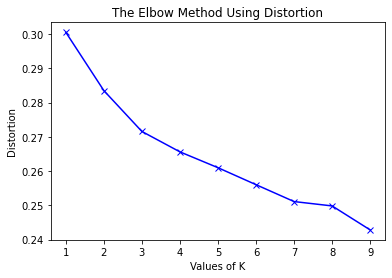

In [102]:
#import plotting library to visualize elbow and silhouette score methods
import matplotlib.pyplot as plt
#loop through distrotion values
for key, val in mapping1.items():
    print(str(key) + ' : '+str(val))
    
#plot distortions vs k   
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method Using Distortion')
plt.show()

For the Elbow Method, the optimal value of K is found at the point of inflection of the Distortion vs K graph. For our graph it seems that the point of inflection occurs at K = 3. We can validate that value using the silhouette score.

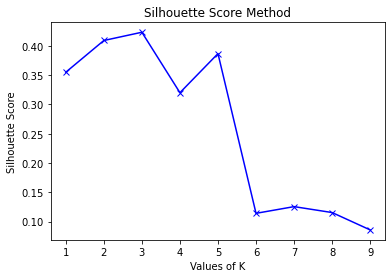

In [103]:
#import library for measuring silhouette score
from sklearn.metrics import silhouette_score
sil = []
kmax = 10
#loop to calculate sil score at each k
for k in range (2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(m_and_t_freq_nolab)
    labels = kmeans.labels_
    sil.append(silhouette_score(m_and_t_freq_nolab, labels, metric = 'euclidean'))

#plot sil vs k
plt.plot(K, sil, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

For the Silhouette Score, the optimal K value occurs at the global maximum of K vs Silhouette Score. For our graph we can see a global maximum at K = 3. Our Elbow Method and Silhouette Score Method are in agreement, K = 3 is the optimal number of clusters for our dataset.

In [104]:
#Perform the clustering again with k = 3
kclusters = 3
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(m_and_t_freq_nolab)
#check labels to ensure they are being produced reasonably
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0,
       2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

Now that we have the cluster labels for each neighborhood, we can display the city, neighborhood, cluster label, and the top five venue categories of each neighborhood.

In [111]:
#combine Manhattan dataframe with top five most common venue types with 
#Toronto dataframe with the same features
m_t_most_common = manhattan_neighborhood_venues_sorted.append(t_n_venues_sorted, ignore_index=True)
#add column of cluster labels into merged dataframe
m_t_most_common.insert(0, 'Cluster Labels', kmeans.labels_)
#reinsert City label
m_t_most_common['City'] = m_and_t_freq['City']
#reorder columns in terms of scale: city > neighborhood > cluster
col1name = 'City'
col3name = 'Cluster Labels'
first_col = m_t_most_common.pop(col1name)
m_t_most_common.insert(0, col1name, first_col)
third_col = m_t_most_common.pop(col3name)
m_t_most_common.insert(2, col3name, third_col)
m_t_most_common.head()

,City,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Battery Park City,2,Park,Hotel,Gym,Coffee Shop,Memorial Site
1,Manhattan,Carnegie Hill,2,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center
2,Manhattan,Central Harlem,2,African Restaurant,Chinese Restaurant,Bar,Seafood Restaurant,American Restaurant
3,Manhattan,Chelsea,2,Coffee Shop,Bakery,American Restaurant,Art Gallery,Café
4,Manhattan,Chinatown,2,Chinese Restaurant,Cocktail Bar,Bakery,Dessert Shop,American Restaurant


Now that we have our neighborhoods labeled with the cluster that they belong to, we can split our dataframe into three separate frames, one for each cluster. This will allow us to identify the cluster to which our client's Manhattan neighborhoods belong, and from there identify the neighborhoods of Toronto that are similar.

# Cluster 1

In [123]:
#cluster labeling starts at 0, so cluster 1 is the cluster with label 0
m_t_most_common.loc[m_t_most_common['Cluster Labels']==0]

,City,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
60,Toronto,Forest Hill SE,0,Playground,Park,Bank,Yoga Studio,Filipino Restaurant
65,Toronto,Henry Farm,0,Tennis Court,Intersection,Park,Lawyer,Yoga Studio
67,Toronto,Humber Bay,0,Pool,Construction & Landscaping,Park,Home Service,Filipino Restaurant
68,Toronto,Humber Valley Village,0,Bakery,Convenience Store,Bus Stop,Skating Rink,Park
70,Toronto,Ionview,0,Metro Station,Deli / Bodega,Park,Yoga Studio,Fish & Chips Shop
75,Toronto,King's Mill Park,0,Park,Playground,Metro Station,Spa,Event Space
81,Toronto,Lawrence Manor East,0,Electronics Store,Doctor's Office,Park,Kids Store,Bank
84,Toronto,Maple Leaf Park,0,Bakery,Construction & Landscaping,Park,Business Service,Fish & Chips Shop
85,Toronto,Markland Wood,0,Baseball Field,Golf Course,Piano Bar,Park,Filipino Restaurant
98,Toronto,Old Burnhamthorpe,0,Dog Run,Gas Station,Flower Shop,Park,Yoga Studio


We can see that Cluster 1 does not contain any Manhattan neighborhoods, and for this will not be very informative to our client.

# Cluster 2

In [124]:
m_t_most_common.loc[m_t_most_common['Cluster Labels']==1]

,City,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
119,Toronto,Steeles East,1,Playground,Yoga Studio,Fish & Chips Shop,Ethiopian Restaurant,Event Service
213,Toronto,South Steeles,1,Playground,Yoga Studio,Fish & Chips Shop,Ethiopian Restaurant,Event Service
215,Toronto,Steeles West,1,Playground,Yoga Studio,Fish & Chips Shop,Ethiopian Restaurant,Event Service


We can also see that the same is true for Cluster 2. All of the neighborhoods belong to Toronto and are very specifically unique. This will not provide our client a lot of information.

# Cluster 3

In [125]:
m_t_most_common.loc[m_t_most_common['Cluster Labels']==2]

,City,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Battery Park City,2,Park,Hotel,Gym,Coffee Shop,Memorial Site
1,Manhattan,Carnegie Hill,2,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center
2,Manhattan,Central Harlem,2,African Restaurant,Chinese Restaurant,Bar,Seafood Restaurant,American Restaurant
3,Manhattan,Chelsea,2,Coffee Shop,Bakery,American Restaurant,Art Gallery,Café
4,Manhattan,Chinatown,2,Chinese Restaurant,Cocktail Bar,Bakery,Dessert Shop,American Restaurant
5,Manhattan,Civic Center,2,Coffee Shop,Gym / Fitness Center,Spa,Cocktail Bar,Hotel
6,Manhattan,Clinton,2,Theater,American Restaurant,Gym / Fitness Center,Coffee Shop,Italian Restaurant
7,Manhattan,East Harlem,2,Mexican Restaurant,Bakery,Thai Restaurant,Deli / Bodega,Latin American Restaurant
8,Manhattan,East Village,2,Bar,Pizza Place,Mexican Restaurant,Ice Cream Shop,Wine Bar
9,Manhattan,Financial District,2,Coffee Shop,Pizza Place,Café,Bar,Cocktail Bar


However, we can see that Cluster 3 not only contains neighborhoods of both Manhattan and Toronto, but that it contains both neighborhoods that our client has locations!

We can see that Carnegie Hill is characterized by coffee shops and cafes, as well as bookstores. Chelsea is similarly characterized by these venue types. For this, we can conclude that Toronto neighborhoods in Cluster 3 should contain a similar clientele to Carnegie Hill and Chelsea.

If we want to explore Cluster 3 more granularly, we can filter down to neighborhoods that have coffee shops as the most common venue.

In [127]:
m_t_cluster3 = m_t_most_common.loc[m_t_most_common['Cluster Labels']==2]
cl3_coffee = m_t_cluster3.loc[m_t_cluster3['1st Most Common Venue']=='Coffee Shop']
cl3_coffee.head(10)

,City,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Manhattan,Carnegie Hill,2,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center
3,Manhattan,Chelsea,2,Coffee Shop,Bakery,American Restaurant,Art Gallery,Café
5,Manhattan,Civic Center,2,Coffee Shop,Gym / Fitness Center,Spa,Cocktail Bar,Hotel
9,Manhattan,Financial District,2,Coffee Shop,Pizza Place,Café,Bar,Cocktail Bar
21,Manhattan,Manhattanville,2,Coffee Shop,Seafood Restaurant,Deli / Bodega,Italian Restaurant,Mexican Restaurant
22,Manhattan,Marble Hill,2,Coffee Shop,Sandwich Place,Discount Store,Gym,Supplement Shop
40,Toronto,Adelaide,2,Coffee Shop,Restaurant,Japanese Restaurant,Café,Gastropub
43,Toronto,Bathurst Quay,2,Coffee Shop,Café,Harbor / Marina,Park,Dance Studio
52,Toronto,Deer Park,2,Coffee Shop,Grocery Store,Italian Restaurant,Thai Restaurant,Restaurant
53,Toronto,Design Exchange,2,Coffee Shop,Restaurant,Café,Hotel,American Restaurant


We can do the same sort of filtering to find neighborhoods even more specifically similar to our client's successful Manhattan neighborhoods. From neighborhoods where coffee shops are the most common venue we can find which of those neighborhoods also have cafés as their second most common venue. This follows the characterization of Carnegie Hill, the Manhattan neighborhood with our client's most succesful location.  Cafés also characterize Chelsea, the neighborhood containing our client's other location, though it is not the second most common venue type in that neighborhood.

In [129]:
cl3_coffee_cafe = cl3_coffee.loc[cl3_coffee['2nd Most Common Venue'] == 'Café']
cl3_coffee_cafe

,City,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Manhattan,Carnegie Hill,2,Coffee Shop,Café,Bookstore,Italian Restaurant,Gym / Fitness Center
43,Toronto,Bathurst Quay,2,Coffee Shop,Café,Harbor / Marina,Park,Dance Studio
61,Toronto,Grange Park,2,Coffee Shop,Café,Sandwich Place,Art Gallery,Arts & Crafts Store
63,Toronto,Harbourfront,2,Coffee Shop,Café,Restaurant,Hotel,Italian Restaurant
64,Toronto,Harbourfront West,2,Coffee Shop,Café,Restaurant,Hotel,Italian Restaurant
177,Toronto,Harbourfront East,2,Coffee Shop,Café,Restaurant,Hotel,Italian Restaurant
205,Toronto,Queen's Park,2,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Bubble Tea Shop
211,Toronto,Runnymede,2,Coffee Shop,Café,Bakery,Bank,Pizza Place
214,Toronto,St. James Town,2,Coffee Shop,Café,Pizza Place,Grocery Store,Indian Restaurant
216,Toronto,Studio District,2,Coffee Shop,Café,Cosmetics Shop,Vegetarian / Vegan Restaurant,Japanese Restaurant


Here we can provide a list of possible neighborhood candidates to our client. Bathurst Quay, Grange Park, Harbourfront (East and West), Queen's Park, Runnymede, St. James Town, and the Studio District all cluster with our client's most succsesful neighborhood Carnegie Hill, and also share the two most common venue types. It stands to reason that these Toronto neighborhoods should contain or attract a similar clientele to the Manhattan neighborhoods that our client is familiar with.

Queen's Park and Harbourfront reveal themselves as particularly interesting candidates as they contain Italian restaurants in addition to the other venues that overlap with Carnegie Hill.